In [0]:
import torch
import torch.nn.functional as F
import torchvision.models as models ## alexnet vgg restnet 등 여러모델 제공
import torchvision.transforms as transforms 

from PIL import Image 
import json
import matplotlib.pyplot as plt


In [26]:
model = models.resnet101(pretrained=True)
model.eval()
##마지막 (classifier): Linear(in_features=1024, out_features=1000, bias=True)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [8]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
DEVICE 

device(type='cuda')

In [0]:
class_url = "/content/gdrive/My Drive/Colab Notebooks/pytorch/Adversarial-Attack/imagenet_classes.json"
CLASSES = json.load(open(class_url))
idx2class = [CLASSES[str(i)] for i in range(1000)]
##class 딕셔러니 만들기~

In [30]:
print(idx2class)

['tench, Tinca tinca', 'goldfish, Carassius auratus', 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 'tiger shark, Galeocerdo cuvieri', 'hammerhead, hammerhead shark', 'electric ray, crampfish, numbfish, torpedo', 'stingray', 'cock', 'hen', 'ostrich, Struthio camelus', 'brambling, Fringilla montifringilla', 'goldfinch, Carduelis carduelis', 'house finch, linnet, Carpodacus mexicanus', 'junco, snowbird', 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 'robin, American robin, Turdus migratorius', 'bulbul', 'jay', 'magpie', 'chickadee', 'water ouzel, dipper', 'kite', 'bald eagle, American eagle, Haliaeetus leucocephalus', 'vulture', 'great grey owl, great gray owl, Strix nebulosa', 'European fire salamander, Salamandra salamandra', 'common newt, Triturus vulgaris', 'eft', 'spotted salamander, Ambystoma maculatum', 'axolotl, mud puppy, Ambystoma mexicanum', 'bullfrog, Rana catesbeiana', 'tree frog, tree-frog', 'tailed frog, bell toad, 

In [0]:
## 코기사진 인터넷에서 긁어와서 이걸로 해보자~
download_img_url = "/content/gdrive/My Drive/Colab Notebooks/pytorch/Adversarial-Attack/corgi.jpg"
img = Image.open(download_img_url)

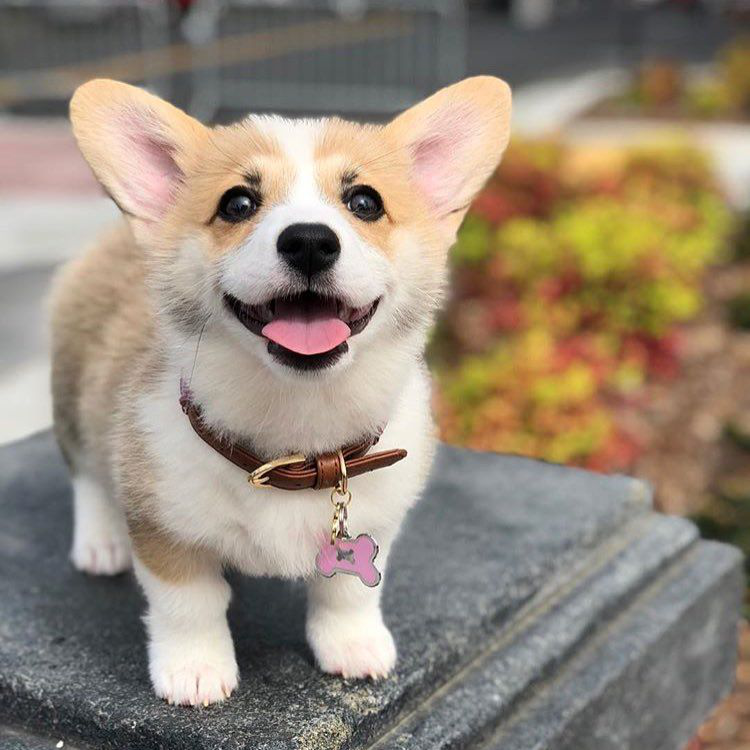

In [15]:
img

In [46]:
## 이미지 넷과 같은 크기인 224*224로 바꾸기 
img_transforms = transforms.Compose([
                                     transforms.Resize((224,224),Image.BICUBIC),
                                     transforms.ToTensor(),
])
img_tensor = img_transforms(img)
## 3 * 224 *224 -> 1* 3 *224 *224로 바꾸기 
img_tensor = img_tensor.unsqueeze(0)

print("이미지 텐서 모양",img_tensor.size())

이미지 텐서 모양 torch.Size([1, 3, 224, 224])


img_size  torch.Size([3, 224, 224])


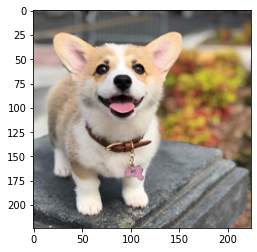

In [47]:
##시각화~ 
#[1,3,224,224] ->[3,224,224]
original_img = img_tensor.squeeze(0).detach()
print("img_size ",original_img.size())
#original_img = original_img.transpose(0,2).transpose(0,1).numpy()
original_img = original_img.transpose(0,2).transpose(0,1).numpy()
plt.imshow(original_img)

In [48]:
## 모델 성능 테스트하기~ 
output = model(img_tensor)
print(output.max(1,keepdim=False))
prediction = output.max(1,keepdim=False)[1]
print(prediction)

prediction_idx = prediction.item()
prediction_name = idx2class[prediction_idx]

print("레이블 번호 ",prediction_idx)
print("레이블 이름",prediction_name)

torch.return_types.max(
values=tensor([16.0224], grad_fn=<MaxBackward0>),
indices=tensor([263]))
tensor([263])
레이블 번호  263
레이블 이름 Pembroke, Pembroke Welsh corgi


In [0]:
##fgsm = 모델에서 입력이미지에 대한 기울기 정보 추출하고 그것을 외곡해서 원본 이미지에 더하는 것 
## 기울기 = 모델이 학습할때 각 픽셀에 미치는 영향 
## 모델의 오찻값을 극대화 하는 방향으로 학습 

def fgsm_attack(image,epsilon,gradient):
  ## 기울기 값 원소의 sign값을 구함
  sign_gradient = gradient.sign()
  ##sign == 0보다작으면 -1 / 0==0 / 0보다 크면 1

  perturbed_image = image + epsilon*sign_gradient ##이미지의 각 픽셀값을 sign_gradient 방향으로 epsilon만큼 조절

  ##[0,1]범위 넘어가는 값 조절
  perturbed_image = torch.clamp(perturbed_image,0,1)
  return perturbed_image

In [0]:
##이미지의 기울기 구하기 
img_tensor.requires_grad_(True)
##이미지에 대한 기울기를 보존하도록 명시 , 하지않으면 기울기가 생성 안됨 

output = model(img_tensor)

##오찻값 구하기
loss = F.nll_loss(output,torch.tensor([263])) ##263 == 코기코기 

##기울기 구하기 
model.zero_grad()
loss.backward()

In [52]:
## img_tensor.grad.data 변수에 입력이미지의 기울기가 저장 
gradient = img_tensor.grad.data
print(gradient.size())

##적대적이미지생성
epsilon= 0.03
perturbed_data = fgsm_attack(img_tensor,epsilon,gradient)


torch.Size([1, 3, 224, 224])


In [53]:
## 만들어진 이미지 다시 테스트 해보기 
output = model(perturbed_data)

perturbed_prediction = output.max(1,keepdim=True)[1]

perturbed_idx = perturbed_prediction.item()
preturbed_class = idx2class[perturbed_idx]

print("label idx : ",perturbed_idx)
print("class :",preturbed_class)

label idx :  270
class : white wolf, Arctic wolf, Canis lupus tundrarum


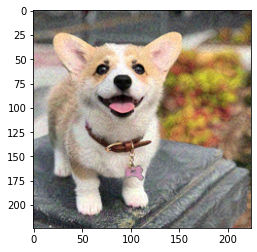

In [54]:
## 시각화 ㄱㄱ 
p_data_view = perturbed_data.squeeze(0).detach()
p_data_view= p_data_view.transpose(0,2).transpose(0,1).numpy()

plt.imshow(p_data_view)

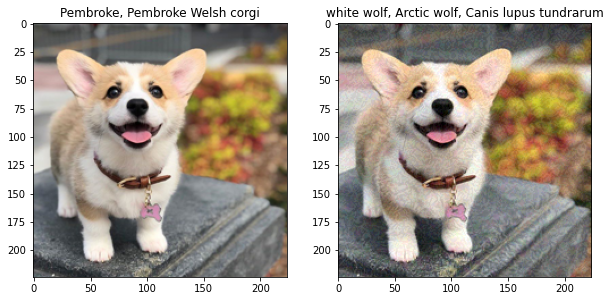

In [57]:
## 원본과 바뀐 사진 보기 
f,a = plt.subplots(1,2,figsize=(10,10))
a[0].set_title(prediction_name)
a[0].imshow(original_img)

a[1].set_title(preturbed_class)
a[1].imshow(p_data_view)

plt.show()